# Processing of the "Construction of non residentials" dataset

## Importing libraries and dataset

In [ ]:
import pandas as pd
import re
from matplotlib import pyplot as plt 
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
# pip install "folium>=0.12" matplotlib mapclassify


SyntaxError: invalid syntax (2067825491.py, line 7)

In [3]:
df = pd.read_csv("https://minio.lab.sspcloud.fr/mligeret1/constructions_non_resid_geocoded.csv",sep=",",on_bad_lines="warn")

/tmp/ipykernel_78342/1214635194.py:1: DtypeWarning: Columns (1,3,5,8,12,18,20,21,22,24,30,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,108,114,116,117) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("https://minio.lab.sspcloud.fr/mligeret1/constructions_non_resid_geocoded.csv",sep=",",on_bad_lines="warn")


In [54]:
df.head()
df = df.iloc[1:]
df.head()



,Unnamed: 0,Code de la région du lieu des travaux - Code de la zone,Code de la région du lieu des travaux - Libellé de la zone,Code du département du lieu des travaux - Code de la zone,Code du département du lieu des travaux - Libellé de la zone,Code de la commune du lieu des travaux,"Type de DAU -- demande d'autorisation d'urbanisme (PC ou DP généralement, rarement PA)",Numéro d'enregistrement de la DAU,Etat d'avancement du projet,Date réelle d'autorisation (PC) ou de non-opposition (DP) initiale,...,result_name,result_street,result_postcode,result_city,result_context,result_citycode,result_oldcitycode,result_oldcity,result_district,result_status
1,1,82,Rhône-Alpes,01,Ain,01001,PC,00100117V0002,5,2017-05-05,...,L'Abergement-Clémenciat,NaN,1400.0,L'Abergement-Clémenciat,"01, Ain, Auvergne-Rhône-Alpes",01001,NaN,NaN,NaN,ok
2,2,82,Rhône-Alpes,01,Ain,01001,PC,00100119V0005,2,2019-08-29,...,203 Rue des 5 Chemins,Rue des 5 Chemins,1400.0,L'Abergement-Clémenciat,"01, Ain, Auvergne-Rhône-Alpes",01001,NaN,NaN,NaN,ok
3,3,82,Rhône-Alpes,01,Ain,01001,PC,00100120V0003,5,2020-05-25,...,172 Route du Château,Route du Château,1400.0,L'Abergement-Clémenciat,"01, Ain, Auvergne-Rhône-Alpes",01001,NaN,NaN,NaN,ok
4,4,82,Rhône-Alpes,01,Ain,01001,DP,00100119V0011,2,2019-07-22,...,Chemin sous Brody,Chemin sous Brody,1400.0,L'Abergement-Clémenciat,"01, Ain, Auvergne-Rhône-Alpes",01001,NaN,NaN,NaN,ok
5,5,82,Rhône-Alpes,01,Ain,01001,DP,00100120V0011,2,2020-04-05,...,Chemin du Sorbier,Chemin du Sorbier,1400.0,L'Abergement-Clémenciat,"01, Ain, Auvergne-Rhône-Alpes",01001,NaN,NaN,NaN,ok


## TODO : Checking for errors in the geocoding
We first check if there are still some lines that were not geocoded during the batch coding (due to time-out). We send individual request to the API. 

In [51]:
df[df["result_status"] == "error"].loc[:,"Adresse_complete"]


277759                  LE VILLAGE Saint-Genies-de-Varensal
277760                   PLAISANCE Saint-Genies-de-Varensal
277761                   Plaisance Saint-Genies-de-Varensal
277762    RTE DEPARTEMENTALE 22E14 LE VILLAGE Saint-Geni...
277763    1bis RUE des Aires Hautes Saint-Genies-de-Font...
277764               RUE DES HORTS Saint-Genies-de-Fontedit
277765          RUE DE LA VICTOIRE Saint-Genies-de-Fontedit
374514         8 Rue de la Baudiniere THOUARiA_oe-SUR-LOIRE
374520              13 Rue de la BaudiniiA_oere THOUARiA_oe
374521                     rue de Milan THOUARi__-SUR-LOIRE
374522            Avenue de la Baudiniere THOUARE-SUR-LOIRE
374523                  4 Rue du Danube THOUARi_ -SUR-LOIRE
374524                  21 Rue de la Baudinii__re THOUARi__
374525      9001 Avenu du Parc des Sports THOUARE SUR LOIRE
374526                      Le Chene-Vert Thouare-sur-Loire
417855                      ZA  de la VERANGERIE Picauville
417858                    Le Coudray Hou

## Grouping columns together
Pour se faire, on regroupe les colonnes de même ordre  


In [5]:
for c in df.columns:
    print(c)

Unnamed: 0
Code de la région du lieu des travaux - Code de la zone
Code de la région du lieu des travaux - Libellé de la zone
Code du département du lieu des travaux - Code de la zone
Code du département du lieu des travaux - Libellé de la zone
Code de la commune du lieu des travaux
Type de DAU -- demande d'autorisation d'urbanisme (PC ou DP généralement, rarement PA)
Numéro d'enregistrement de la DAU
Etat d'avancement du projet
Date réelle d'autorisation (PC) ou de non-opposition (DP) initiale
Date réelle d'ouverture de chantier
Date réelle d'achèvement des travaux
Année de dépôt de la DAU
Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)
Date (mois) de prise en compte (DPC) de l'autorisation initiale
Date (mois) de prise en compte (DPC) de l'ouverture du chantier
Date (mois) (DPC) de dernière mise à jour des données
Code d'activité principale de l'établissement d'un demandeur avéré en tant que personne morale
Catégorie j

In [ ]:
col_metadata = [x for x in df.columns if "DAU" in x] + ["Unnamed: 0"]
col_meta_location = [x for x in df.columns if "lieu des travaux" in x]
col_dates_travaux = [x for x in df.columns if ("Date" in x or "Année" in x)]
col_demandeurs = [x for x in df.columns if "demandeur" in x and ("Nature du projet déclarée par le demandeur" not in x)]
col_precise_location = [x for x in df.columns if "du terrain" in x and ("Superficie du terrain" not in x)] 
col_cadastres = [x for x in df.columns if "cadastre" in x]
col_construction_details = [x for x in df.columns if "Indicateur" in x] + ["Nombre de niveaux du bâtiment le plus élevé","Nombre de chambres (hôtels et autres hébergements, notamment sociaux)"]
col_details_transf = [x for x in df.columns if "Surface de plancher" in x]
col_from_geocodage = [i for i in df.columns if "result_" in i]

col_irrelevant = col_metadata + col_dates_travaux + col_precise_location + col_cadastres + col_construction_details + col_details_transf + col_from_geocodage
col_relevant =  [c for c in df.columns if c not in col_irrelevant] + ["Année de dépôt de la DAU"] 
for c in col_relevant:
    print(c)

Code de la région du lieu des travaux - Code de la zone
Code de la région du lieu des travaux - Libellé de la zone
Code du département du lieu des travaux - Code de la zone
Code du département du lieu des travaux - Libellé de la zone
Code de la commune du lieu des travaux
Etat d'avancement du projet
Code d'activité principale de l'établissement d'un demandeur avéré en tant que personne morale
Catégorie juridique d'un demandeur avéré en tant que personne morale
Dénomination d'un demandeur avéré en tant que personne morale
Numéro SIREN d'un demandeur avéré en tant que personne morale
Numéro SIRET d'un demandeur avéré en tant que personne morale
Code postal du demandeur
Localité du demandeur
Superficie du terrain
Code zone opératoire
Nature du projet déclarée par le demandeur
Nature de projet détaillée
Destination principale
Type principal de transformation
Type principal des locaux d'origine transformés
Type de service public ou d'intérêt collectif
Adresse_complete
longitude
latitude
Ann

In [38]:
df.loc[:,col_relevant].sample(50)



,Code de la région du lieu des travaux - Code de la zone,Code de la région du lieu des travaux - Libellé de la zone,Code du département du lieu des travaux - Code de la zone,Code du département du lieu des travaux - Libellé de la zone,Code de la commune du lieu des travaux,Etat d'avancement du projet,Code d'activité principale de l'établissement d'un demandeur avéré en tant que personne morale,Catégorie juridique d'un demandeur avéré en tant que personne morale,Dénomination d'un demandeur avéré en tant que personne morale,Numéro SIREN d'un demandeur avéré en tant que personne morale,...,Nature du projet déclarée par le demandeur,Nature de projet détaillée,Destination principale,Type principal de transformation,Type principal des locaux d'origine transformés,Type de service public ou d'intérêt collectif,Adresse_complete,longitude,latitude,Année de dépôt de la DAU
404081,52,Pays de la Loire,49,Maine-et-Loire,49099,6,41.10D,5202.0,WESTEA,898471438.0,...,1,1,8,NaN,NaN,7,rue Pierre Gilles de Gennes - CHOLET,-0.922619,47.023089,2021
722246,54,Poitou-Charentes,86,Vienne,86070,2,35.13Z,5710.0,SRD,502035785.0,...,1,1,6,NaN,NaN,7,RUE de la Triaudiere Villeneuve Chauvigny,0.662708,46.536936,2022
624600,11,Île-de-France,75,Paris,75056,5,47.79Z,5499.0,GALERIE JACQUES LACOSTE,338285356.0,...,2,6,4,NaN,NaN,7,19 AVENUE MATIGNON PARIS 08,2.313029,48.870723,2025
268250,91,Languedoc-Roussillon,34,Hérault,34013,2,01.21Z,6598.0,DOMAINE RIBIERA,530251842.0,...,1,1,7,NaN,NaN,7,VALAT DE LA MALAOUTIE Aspiran,3.450266,43.569636,2013
254307,72,Aquitaine,33,Gironde,33215,2,01.21Z,5710.0,VIGNOBLES JAUBERT,394341739.0,...,1,1,7,NaN,NaN,7,LIEU-DIT LES COMBES LADAUX,-1.362347,46.720533,2022
364344,52,Pays de la Loire,44,Loire-Atlantique,44102,2,01.47Z,6598.0,LA FERME DES HAUTES GRANGES,830062006.0,...,1,1,7,NaN,NaN,7,LA HAUTE GRANGE MONTBERT,-1.446236,47.078317,2021
29972,93,Provence-Alpes-Côte d'Azur,6,Alpes-Maritimes,6088,2,NaN,NaN,NaN,NaN,...,2,2,1,3.0,1.0,6,60 BD PAUL MONTEL NICE,7.207424,43.675131,2021
253851,72,Aquitaine,33,Gironde,33213,2,NaN,NaN,NaN,NaN,...,2,6,1,NaN,NaN,7,16 BI ALLÉE PERRUCADE LA BREDE,-0.515153,44.685771,2015
636593,23,Haute-Normandie,76,Seine-Maritime,76340,2,NaN,NaN,NaN,NaN,...,2,5,5,NaN,NaN,7,350 route de la Gare HARCANVILLE,0.772774,49.719892,2022
742529,11,Île-de-France,91,Essonne,91027,6,68.20B,5710.0,AVENA CAPITAL,830625117.0,...,1,1,9,NaN,NaN,3,38 avenue Jules Valles ATHIS MONS,2.376179,48.700219,2017


<Axes: >

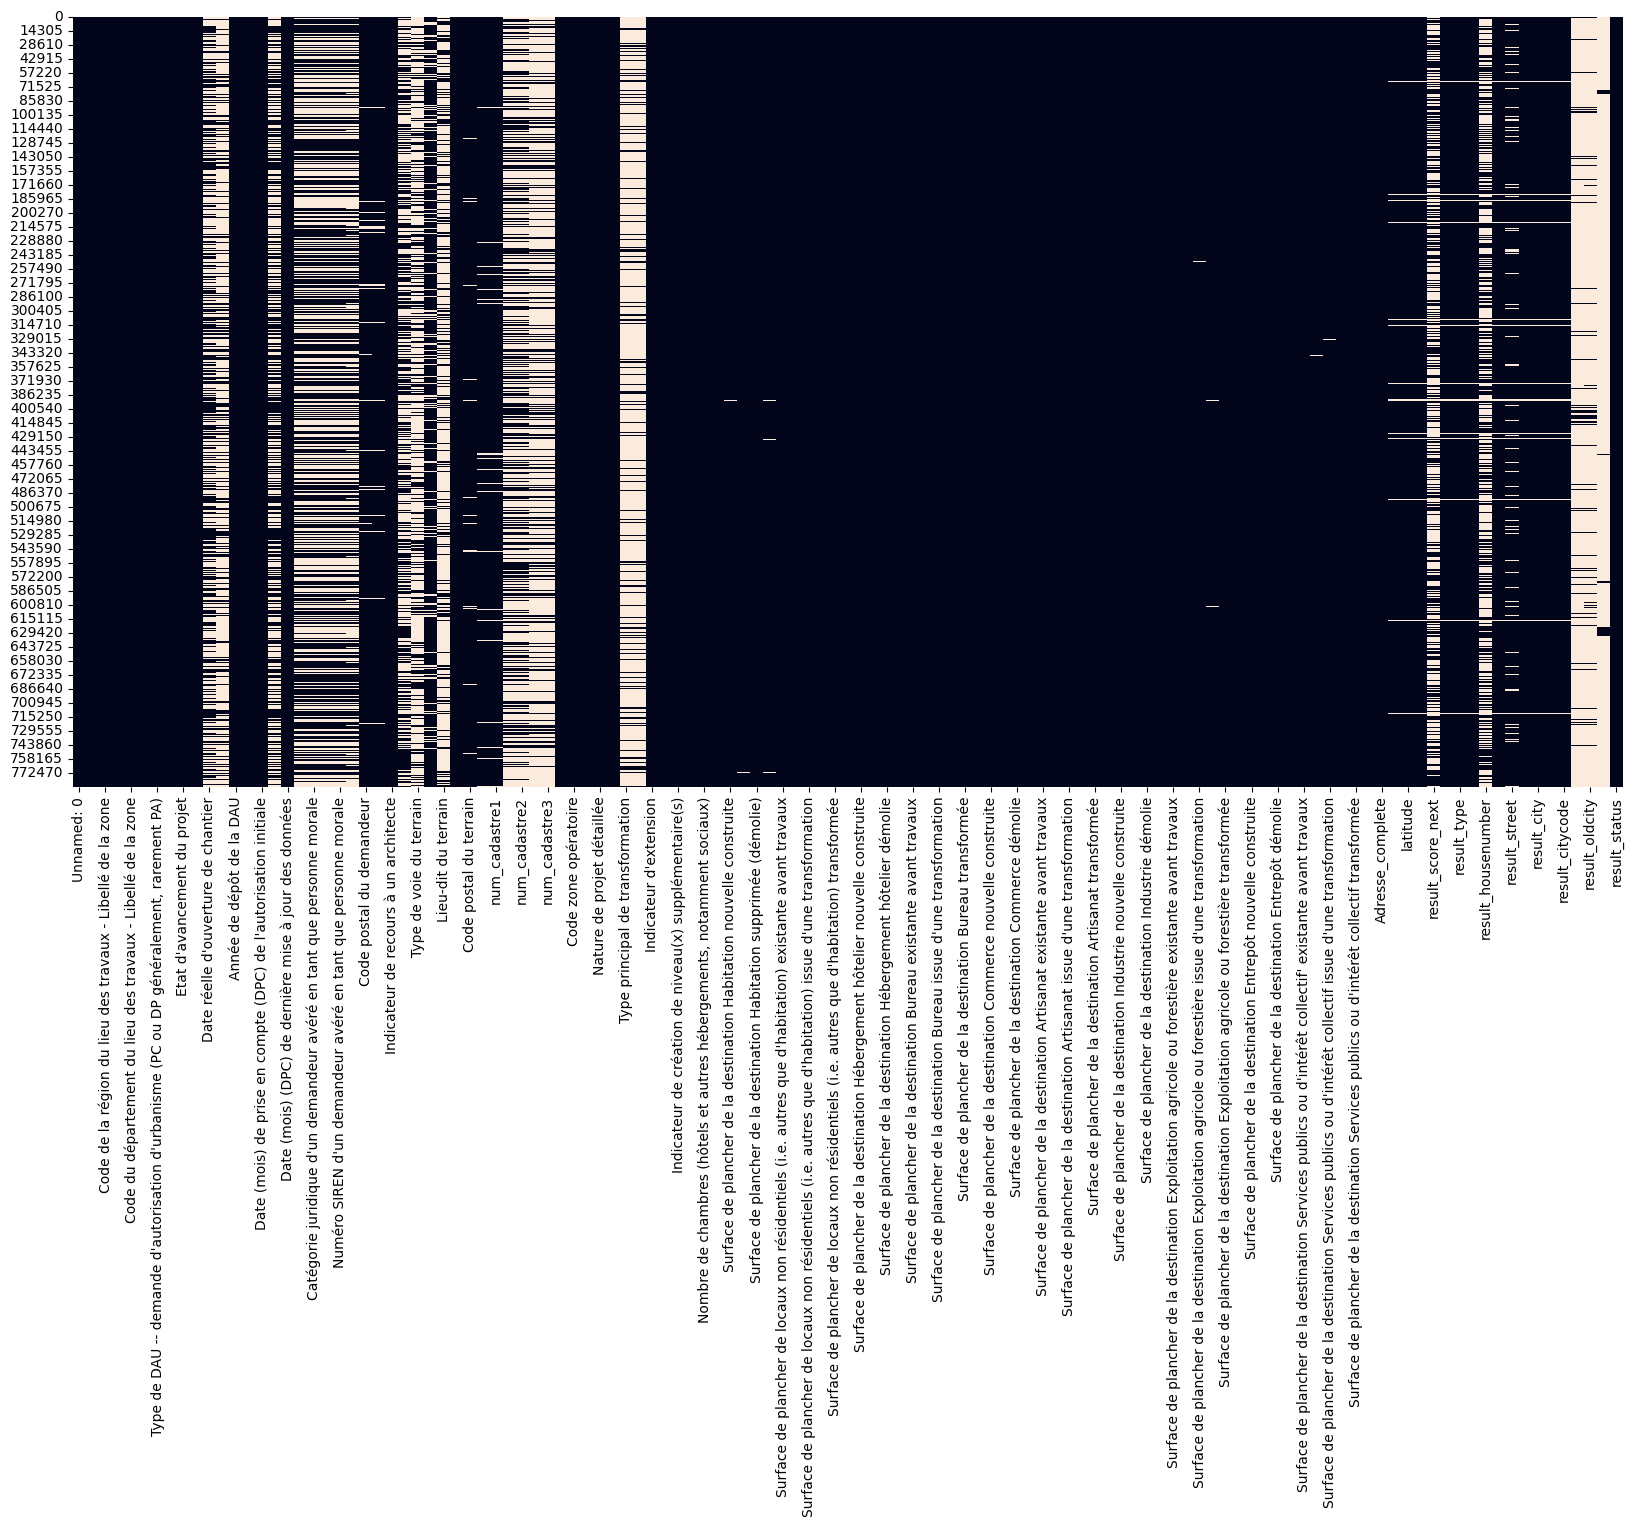

In [58]:
plt.figure(figsize=(20,10))

sns.heatmap(df.isna(), cbar=False)


In [ ]:
def identification_usage(ligne):
    col_max = ligne.iloc[len(dates_lieux_travaux):].idxmax()
    pattern = r"Surface de plancher de la destination (.+?) (nouvelle construite|issue d'une transformation)$"

    match = re.search(pattern, col_max, re.IGNORECASE)
    print("Testing column:", repr(col_max))
    return match.group(1) if match else None

df_usage = df.loc[:,colonnes_pertinentes].sample(1000)
df_usage["Destination du lieu"]= df_usage.apply(identification_usage, axis = 1)



Testing column: 'Surface de plancher de la destination Exploitation agricole ou forestière nouvelle construite'
Testing column: 'Surface de plancher de la destination Artisanat nouvelle construite'
Testing column: 'Surface de plancher de la destination Commerce nouvelle construite'
Testing column: 'Surface de plancher de la destination Exploitation agricole ou forestière nouvelle construite'
Testing column: 'Surface de plancher de la destination Industrie nouvelle construite'
Testing column: 'Surface de plancher de la destination Habitation nouvelle construite'
Testing column: 'Surface de plancher de la destination Habitation nouvelle construite'
Testing column: "Surface de plancher de la destination Services publics ou d'intérêt collectif nouvelle construite"
Testing column: 'Surface de plancher de la destination Artisanat nouvelle construite'
Testing column: 'Surface de plancher de la destination Industrie nouvelle construite'
Testing column: 'Surface de plancher de la destination In

## Arranging columns types 


In [46]:
dico_variables = pd.read_excel("https://minio.lab.sspcloud.fr/mligeret1/dictionnaire-variables-locaux-permis-construire-20220531.xls")

### Régler la question de la date 

In [ ]:
dico_variables.head()df["Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)"].value_counts().to_frame().style #to verify that dates are well specified under the format %Y%m, i.e. year with 4 digits followed by month
df["Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)"] = pd.to_datetime(df["Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)"], format="%Y-%m", errors="coerce")

We repeat the operation for the other columns that involve date/year dtypes
for col_date in col_dates_travaux:
    print(df[col_date].value_counts().to_frame()) #to verify the format of the date

col_date_format_ymd = [col_dates_travaux[i] for i in [0,1,2,4]]
col_date_format_y = [col_dates_travaux[i] for i in [3]]
col_date_format_ym = [col_dates_travaux[i] for i in [5,6,7]]

for col in col_date_format_ymd:
    print(df[col])
    df[col] = pd.to_datetime(df[col], format="%Y-%m-%d", errors="coerce")

for col in col_date_format_ym:
    print(df[col])
    df[col] = pd.to_datetime(df[col], format="%Y-%m", errors="coerce")

for col in col_date_format_y:
    df[col] = pd.to_datetime(df[col], format="%Y", errors="coerce")


,Nom de la variable,Description de la variable,Nouveau mai 2022?,Modalités,Format,Observations,Origine
0,REG,Code de la région du lieu des travaux,NaN,Nomenclature du Code Officiel Géographique (CO...,"Alphanumérique, 2 caractères",NaN,Numéro d'enregistrement de la DAU
1,DEP,Code du département du lieu des travaux,NaN,NaN,"Alphanumérique, 2 caractères",NaN,Numéro d'enregistrement de la DAU
2,COMM,Code de la commune du lieu des travaux,NaN,Nomenclature du Code Officiel Géographique (CO...,"Alphanumérique, 5 caractères",Le code vient directement du numéro d'enregist...,Numéro d'enregistrement de la DAU
3,Type_DAU,Type de DAU -- demande d'autorisation d'urbani...,NaN,PC (Permis de construire)\nDP (Déclaration Pré...,"Alphanumérique, 2 caractères",NaN,Numéro d'enregistrement de la DAU
4,Num_DAU,Numéro d'enregistrement de la DAU,NaN,NaN,"Alphanumérique, 13 caractères",Numéro sur 13 caractères : les 6 premiers cara...,Numéro d'enregistrement de la DAU


### Retrouver depuis le dictionnaire 

In [47]:
def variable_types(ligne):
    if "Alphanumérique" in ligne["Format"]:
        return "string"
    if "Numérique" in ligne["Format"]:
        return "Int64"
        
dico_variables["Format_python"] = dico_variables.apply(variable_types, axis=1)


In [48]:
dtype_map = dict(zip(dico_variables["Description de la variable"], dico_variables["Format_python"]))
dtype_map = {col : python_type for col, python_type in dtype_map.items() if col in df.columns}
df = df.astype(dtype_map, errors="ignore")


In [49]:
df.dtypes.to_frame().style

,0
Unnamed: 0,int64
Code de la région du lieu des travaux - Code de la zone,object
Code de la région du lieu des travaux - Libellé de la zone,object
Code du département du lieu des travaux - Code de la zone,object
Code du département du lieu des travaux - Libellé de la zone,object
Code de la commune du lieu des travaux,string
"Type de DAU -- demande d'autorisation d'urbanisme (PC ou DP généralement, rarement PA)",string
Numéro d'enregistrement de la DAU,string
Etat d'avancement du projet,string
Date réelle d'autorisation (PC) ou de non-opposition (DP) initiale,datetime64[ns]


### Compléter les dernières colonnes

In [61]:
df = df.astype({col : "float64" for col in col_details_transf + ["Superficie du terrain"]})

df = df.astype({col : "string" for col in col_meta_location + col_cadastres + ["Code zone opératoire"]})
df = df.astype({col : "string" for col in ["Adresse_complete"]})


In [62]:
df.dtypes.to_frame().style

,0
Unnamed: 0,int64
Code de la région du lieu des travaux - Code de la zone,string
Code de la région du lieu des travaux - Libellé de la zone,string
Code du département du lieu des travaux - Code de la zone,string
Code du département du lieu des travaux - Libellé de la zone,string
Code de la commune du lieu des travaux,string
"Type de DAU -- demande d'autorisation d'urbanisme (PC ou DP généralement, rarement PA)",string
Numéro d'enregistrement de la DAU,string
Etat d'avancement du projet,string
Date réelle d'autorisation (PC) ou de non-opposition (DP) initiale,datetime64[ns]


## First descriptive statistics 

### Main usage of the building before and after 

In [17]:
df["Destination principale"].value_counts()

Destination principale
7                         165977
9                         157836
1                         129660
4                          84580
8                          82167
3                          65829
6                          44744
5                          43730
2                          12215
DESTINATION_PRINCIPALE         1
Name: count, dtype: Int64

In [20]:
df["Type principal des locaux d'origine transformés"].value_counts()

Type principal des locaux d'origine transformés
1.0                                49456
4.0                                17054
8.0                                13608
3.0                                12599
9.0                                 9594
7.0                                 8754
5.0                                 5218
6.0                                 3077
2.0                                 1713
1                                    382
8                                    151
7                                    137
4                                    128
5                                     95
9                                     89
3                                     64
6                                     50
2                                     20
TYPE_PRINCIP_LOCAUX_TRANSFORMES        1
Name: count, dtype: Int64

### Construction Activity Time Series

In [65]:
df["Date"] = df["Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)"]


<Axes: xlabel='Année de dépôt de la DAU'>

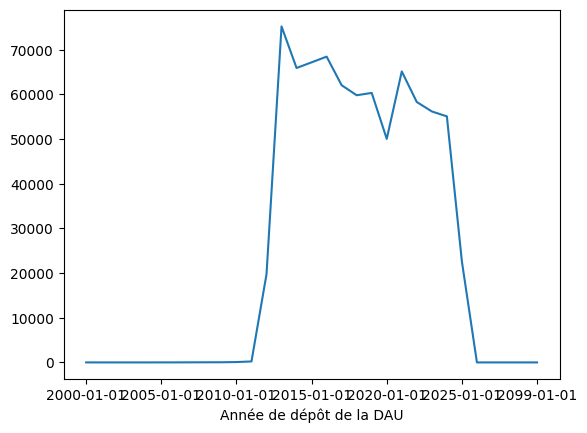

In [71]:
df["Année de dépôt de la DAU"].value_counts().sort_index().plot()

<Axes: xlabel='Date'>

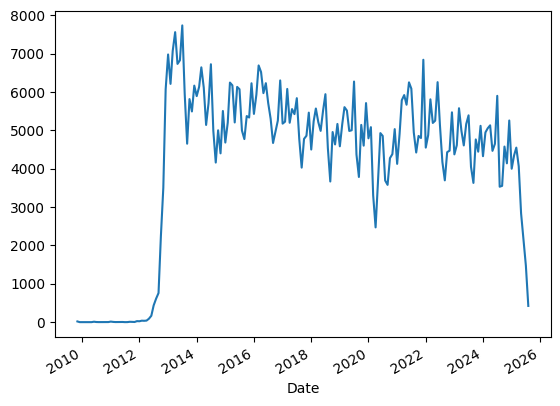

In [66]:
df["Date"].value_counts().sort_index().plot()


(array([2.2000e+01, 2.1000e+01, 2.0000e+01, 2.0000e+01, 2.6000e+01,
        1.3100e+02, 1.3480e+03, 1.2578e+04, 3.4572e+04, 3.0994e+04,
        3.0346e+04, 2.3703e+04, 2.4068e+04, 2.7526e+04, 2.1986e+04,
        2.8306e+04, 3.1141e+04, 2.6510e+04, 2.1691e+04, 2.5639e+04,
        2.4852e+04, 2.1298e+04, 2.3754e+04, 2.6056e+04, 2.4429e+04,
        2.0258e+04, 1.9449e+04, 2.0793e+04, 2.5784e+04, 2.2966e+04,
        2.5482e+04, 2.7403e+04, 1.7444e+04, 2.4521e+04, 2.4214e+04,
        2.2295e+04, 1.9607e+04, 2.2222e+04, 2.2310e+04, 1.0953e+04]),
 array([14549. , 14692.8, 14836.6, 14980.4, 15124.2, 15268. , 15411.8,
        15555.6, 15699.4, 15843.2, 15987. , 16130.8, 16274.6, 16418.4,
        16562.2, 16706. , 16849.8, 16993.6, 17137.4, 17281.2, 17425. ,
        17568.8, 17712.6, 17856.4, 18000.2, 18144. , 18287.8, 18431.6,
        18575.4, 18719.2, 18863. , 19006.8, 19150.6, 19294.4, 19438.2,
        19582. , 19725.8, 19869.6, 20013.4, 20157.2, 20301. ]),
 <BarContainer object of 40 artists

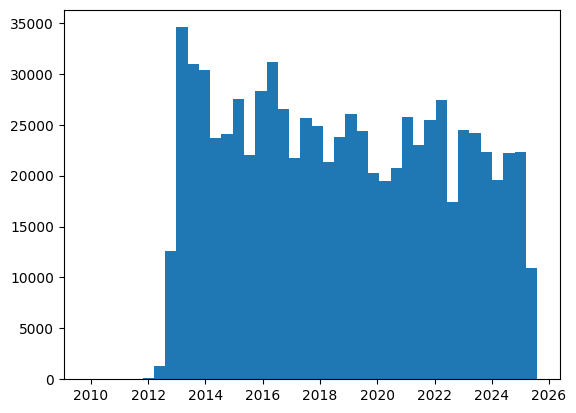

In [70]:
plt.hist(df["Date"], bins=40)    # Histogramme


In [101]:
activity_per_department = df.groupby(["Code de la région du lieu des travaux - Code de la zone", "Année de dépôt de la DAU"]).size().unstack(1).sort_index()
activity_per_department["2015-01-01"].sort_values()


Code de la région du lieu des travaux - Code de la zone
3      109.0
6      130.0
2      214.0
1      263.0
4      675.0
94     680.0
74    1103.0
42    1379.0
23    1393.0
43    1447.0
41    1503.0
22    1504.0
21    1539.0
26    1848.0
25    1921.0
83    2276.0
54    2400.0
24    2561.0
31    2632.0
91    3252.0
11    4061.0
53    4372.0
52    4703.0
73    4706.0
82    5870.0
93    6193.0
72    8468.0
Name: 2015-01-01, dtype: float64

### Représentation via carte

In [78]:
df.loc[:,col_relevant].head()

,Code de la région du lieu des travaux - Code de la zone,Code de la région du lieu des travaux - Libellé de la zone,Code du département du lieu des travaux - Code de la zone,Code du département du lieu des travaux - Libellé de la zone,Code de la commune du lieu des travaux,Etat d'avancement du projet,Code d'activité principale de l'établissement d'un demandeur avéré en tant que personne morale,Catégorie juridique d'un demandeur avéré en tant que personne morale,Dénomination d'un demandeur avéré en tant que personne morale,Numéro SIREN d'un demandeur avéré en tant que personne morale,...,Nature du projet déclarée par le demandeur,Nature de projet détaillée,Destination principale,Type principal de transformation,Type principal des locaux d'origine transformés,Type de service public ou d'intérêt collectif,Adresse_complete,longitude,latitude,Année de dépôt de la DAU
1,82,Rhône-Alpes,01,Ain,01001,5,01.50Z,6533,GROUPEMENT AGRICOLE D'EXPLOITATION EN COMMUN R...,434449088,...,1,1,7,<NA>,<NA>,7,ABERGEMENT CLEMENCIAT,4.926588,46.151812,2017-01-01
2,82,Rhône-Alpes,01,Ain,01001,2,01.61Z,6316,CUMA DE L'ABERGEMENT CLEMENCIAT,779289941,...,2,5,3,<NA>,<NA>,7,203 Rue des cinq Chemins ABERGEMENT CLEMENCIAT,4.922429,46.152118,2019-01-01
3,82,Rhône-Alpes,01,Ain,01001,5,<NA>,<NA>,<NA>,<NA>,...,1,1,9,<NA>,<NA>,6,172 Route du Chateau ABERGEMENT CLEMENCIAT,4.920218,46.152497,2020-01-01
4,82,Rhône-Alpes,01,Ain,01001,2,<NA>,<NA>,<NA>,<NA>,...,2,5,7,<NA>,<NA>,7,Sur Brody ABERGEMENT CLEMENCIAT,4.915929,46.163314,2019-01-01
5,82,Rhône-Alpes,01,Ain,01001,2,61.10Z,5599,FRANCE TELECOM,380129866,...,1,1,9,<NA>,<NA>,5,LE SORBIER ABERGEMENT CLEMENCIAT,4.927541,46.137953,2020-01-01


In [81]:
df['Geometry'] = df.apply(
    lambda x: Point(x["longitude"], x["latitude"]) 
    if x["longitude"] and x["latitude"] 
    else None,
    axis = 1
)
gdf = gpd.GeoDataFrame(
    df,              # les données
    geometry="Geometry",     # La colonne de géométrie
    crs='EPSG:4326'       # Système de coordonnées WGS84
)



In [ ]:
gdf.head()

NameError: name 'gdf_explore' is not defined